## Scope of this file
- an example of graph classification using GIN

## Dataset description
IMDB-BINARY is a movie collaboration dataset that consists of the ego-networks of 1,000 actors/actresses who played roles in movies in IMDB. In each graph, nodes represent actors/actress, and there is an edge between them if they appear in the same movie. These graphs are derived from the Action and Romance genres. [more](https://paperswithcode.com/dataset/imdb-binary#:~:text=IMDB-BINARY%20is%20a%20movie%20collaboration%20dataset%20that%20consists,are%20derived%20from%20the%20Action%20and%20Romance%20genres.)

## Load Dataset

In [1]:
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='/Datasets/', name='IMDB-BINARY')

## Data exploration

Number of graphs: 1000
Number of average nodes: 19.773
Number of average edges: 193.062
Number of node features: 0
Number of graph classes: 2
Number of class 0: 500
Number of class 1: 500


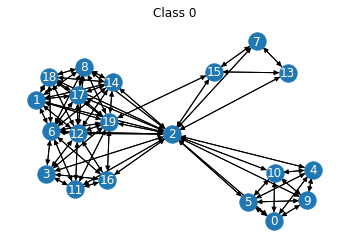

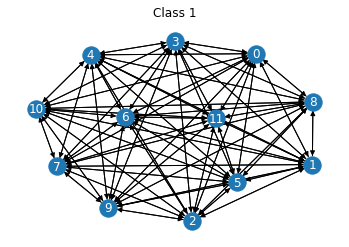

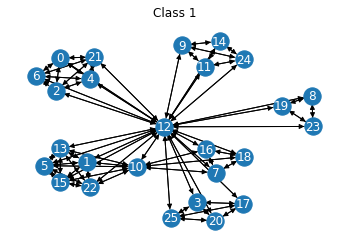

In [2]:
import networkx as nx
from matplotlib import pyplot as plt
from torch_geometric.utils import to_networkx

# Dataset statistic
print('Number of graphs:', len(dataset))
print('Number of average nodes:', dataset.data.num_nodes / len(dataset))
print('Number of average edges:', dataset.data.edge_index.shape[1] / len(dataset))
print('Number of node features:', dataset.num_node_features)
print('Number of graph classes:', dataset.num_classes)

all_y = [graph.y.item() for graph in dataset]
print('Number of class 0:', all_y.count(0))
print('Number of class 1:', all_y.count(1))

# show the first, one middle and the last graph
def show_graph(graph):
    plt.title('Class {}'.format(graph.y.item()))
    graph_nx = to_networkx(graph)
    nx.draw(graph_nx, with_labels=True, font_color='white')
    plt.show()

show_graph(dataset[0])
show_graph(dataset[500])
show_graph(dataset[-1])

## Generate node features using its degree info

In [3]:
import torch
import torch_geometric.transforms as T
from torch_geometric.utils import degree

max_degree = 0
for batch_graphs in dataset:
    max_degree = max(max_degree, degree(batch_graphs.edge_index[0], dtype=torch.long).max().item())
dataset.transform = T.OneHotDegree(max_degree)

print('Number of node features:', dataset[0].num_features)
print('An example of a node features is:\n', dataset[0].x)

Number of node features: 136
An example of a node features is:
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


## Build GNN
###  based on GIN
from [github](https://github.com/rusty1s/pytorch_geometric/blob/master/benchmark/kernel/gin.py)


In [4]:
from torch.nn import Linear, Sequential, ReLU, BatchNorm1d
from torch_geometric.nn.conv import GINConv
from torch_geometric.nn.pool import global_mean_pool
from torch.functional import F

class GIN(torch.nn.Module):
    def __init__(self, ds, num_layers, hidden):
        super(GIN, self).__init__()
        self.conv1 = GINConv(Sequential(
            Linear(ds.num_features, hidden),
            ReLU(),
            Linear(hidden, hidden),
            ReLU(),
            BatchNorm1d(hidden),
        ),
            train_eps=True)
        self.convs = torch.nn.ModuleList()
        for i in range(num_layers - 1):
            self.convs.append(
                GINConv(Sequential(
                    Linear(hidden, hidden),
                    ReLU(),
                    Linear(hidden, hidden),
                    ReLU(),
                    BatchNorm1d(hidden),
                ),
                    train_eps=True))
        self.lin1 = Linear(hidden, hidden)
        self.lin2 = Linear(hidden, ds.num_classes)

    def reset_parameters(self):
        self.conv1.reset_parameters()
        for conv in self.convs:
            conv.reset_parameters()
        self.lin1.reset_parameters()
        self.lin2.reset_parameters()

    def forward(self, batch_data):
        x, edge_index, batch = batch_data.x, batch_data.edge_index, batch_data.batch

        x = self.conv1(x, edge_index)
        for conv in self.convs:
            x = conv(x, edge_index)

        x = global_mean_pool(x, batch)  # readout layout, return (batch_size x hidden)

        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return F.log_softmax(x, dim=-1)

    def __repr__(self):
        return self.__class__.__name__

### based on GCN model

In [7]:
from torch_geometric.nn.conv import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, ds, hidden):
        super().__init__()
        self.conv1 = GCNConv(in_channels=ds.num_node_features, out_channels=hidden)
        self.conv2 = GCNConv(in_channels=hidden, out_channels=hidden)
        self.lin1 = Linear(hidden, hidden)
        self.lin2 = Linear(hidden, ds.num_classes)

    def reset_parameters(self):
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()
        self.lin1.reset_parameters()
        self.lin2.reset_parameters()

    def forward(self, batch_data):
        x, edge_index, batch = batch_data.x, batch_data.edge_index, batch_data.batch

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index) # (batch_size * num_nodes, hidden)

        x = global_mean_pool(x, batch)  # (batch_size, hidden)

        x = F.relu(self.lin1(x))  # (batch_size, hidden)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)   # (batch_size, num_class)
        return F.log_softmax(x, dim=1)

## Train Model

In [15]:
from torch_geometric.loader import DataLoader

model = GIN(dataset, 3, 128)
# model = GCN(dataset, 128)
model.reset_parameters()

dataset.shuffle()
train_dataset = dataset[:600]
test_dataset = dataset[600:]
train_loader = DataLoader(train_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)
train_eval_loader = DataLoader(train_dataset, batch_size=len(train_dataset))
test_eval_loader = DataLoader(test_dataset, batch_size=len(test_dataset))
data_loader = DataLoader(dataset, batch_size=len(dataset))

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def calculate_loss(f, _data_loader):
    data_loss = 0
    for batch_data in _data_loader:
        y = f(batch_data)
        data_loss += F.nll_loss(y, batch_data.y)
    return data_loss.item()


train_loss_ls = []
test_loss_ls = []
for epoch in range(200):
    if epoch % 10 == 1:
        print('Epoch {:03}, Train Loss {:.2f}, Test Loss {:.2f}'.format(epoch, train_loss_ls[-1], test_loss_ls[-1]))
        model.eval()

        correct = 0
        for graphs in train_eval_loader:
            output = model(graphs)
            pred = output.max(dim=1)[1]
            correct += pred.eq(graphs.y).sum().item()
        print('Train Accuracy:{:.2%}'.format(correct / len(train_dataset)))

        correct = 0
        for graphs in test_eval_loader:
            output = model(graphs)
            pred = output.max(dim=1)[1]
            correct += pred.eq(graphs.y).sum().item()
        print('Test Accuracy:{:.2%}'.format(correct / len(test_dataset)))

        correct = 0
        for graphs in data_loader:
            output = model(graphs)
            pred = output.max(dim=1)[1]
            correct += pred.eq(graphs.y).sum().item()
        print('Total Accuracy:{:.2%}'.format(correct / len(dataset)))

    model.train()
    for batch_graphs in train_loader:
        optimizer.zero_grad()
        output = model(batch_graphs)
        loss = F.nll_loss(output, batch_graphs.y)
        loss.backward()
        optimizer.step()
    model.eval()
    train_loss_ls.append(calculate_loss(model, train_eval_loader))
    test_loss_ls.append(calculate_loss(model, test_eval_loader))

Epoch 001, Train Loss 2.02, Test Loss 12.30
Train Accuracy:83.33%
Test Accuracy:0.00%
Total Accuracy:50.00%
Epoch 011, Train Loss 1.06, Test Loss 3.77
Train Accuracy:64.83%
Test Accuracy:41.75%
Total Accuracy:55.60%
Epoch 021, Train Loss 0.40, Test Loss 1.47
Train Accuracy:83.17%
Test Accuracy:40.00%
Total Accuracy:65.90%
Epoch 031, Train Loss 0.48, Test Loss 2.07
Train Accuracy:82.33%
Test Accuracy:39.25%
Total Accuracy:65.10%
Epoch 041, Train Loss 0.61, Test Loss 2.13
Train Accuracy:80.33%
Test Accuracy:18.25%
Total Accuracy:55.50%
Epoch 051, Train Loss 0.42, Test Loss 2.33
Train Accuracy:85.00%
Test Accuracy:10.25%
Total Accuracy:55.10%
Epoch 061, Train Loss 0.47, Test Loss 2.43
Train Accuracy:85.50%
Test Accuracy:9.25%
Total Accuracy:55.00%
Epoch 071, Train Loss 1.40, Test Loss 0.54
Train Accuracy:38.00%
Test Accuracy:89.50%
Total Accuracy:58.60%
Epoch 081, Train Loss 2.05, Test Loss 0.57
Train Accuracy:39.67%
Test Accuracy:88.50%
Total Accuracy:59.20%
Epoch 091, Train Loss 1.11, T

### Evaluate model training

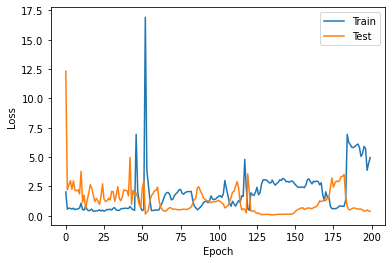

In [16]:
plt.plot(train_loss_ls, label='Train')
plt.plot(test_loss_ls, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()